In [1]:
from queue import Queue
import numpy as np
import math
from operator import itemgetter

edge_count = 0

class SystolicArrayCell:
    def __init__(self, row_n, col_n):
        self.pos_x = 0
        self.pos_y = 0
        self.row_n = row_n
        self.col_n = col_n
        
        #ring register
        self.receive_cell = None  #接收数据寄存器
        self.receive_reg = 1
        self.receive_out = 0
        #self.send    =   #发送数据寄存器
        
        #On chip buffer
        self.result_bank_input = None
        
        #edge update
        self.process_id = 0
        self.process_id_out = 0
        self.next_src = -1
        self.next_dst = -1
        self.src = -1
        self.dst = -1
        self.rb_depth = 0
        self.rb_value = 0
        self.edge_empty   = False
        self.edge_compute = True
        self.hold         = False
        self.edge_number = 0

    # Connects this cell to its neighbors above and to the left
    def connect(self, pos_x, pos_y, array):
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.edge_number = pos_y
        #ring dataflow
        if self.pos_y is array.row_n-1:
            self.receive_cell = array.cells[0][self.pos_x] #cell 第一个代表行数，也就是Y， 第二个代表列数，也就是X
        # Otherwise, it's another cell
        else:
            self.receive_cell = array.cells[self.pos_y+1][self.pos_x]
        #each PE on the same row connect to the same result bank
        self.result_bank_input = array.result_bank[self.pos_y][self.pos_x]
        self.edge_bank         = array.edge_bank[self.pos_y]

    def set_process_id(self, idx):
        self.process_id = idx
        
    # We'll model the transfer of signals through registers with a read() and a
    # compute() method. 
    # read() represents the registers sampling data at the positive edge of the
    # clock
    def read(self, edge_update):
        #ring dataflow 
        #print("Enter | cell({:d},{:d}) next_src {:d}, next_dst {:d}, src {:d}, dst {:d}, process_id {:d}". format(self.pos_x, self.pos_y, self.next_src, self.next_dst, self.src, self.dst, self.process_id))
        if self.edge_bank.empty():
            self.edge_empty = True
        elif self.edge_compute or edge_update:
            self.src, self.dst = self.edge_bank.get()
            self.hold         = True
            self.edge_compute = False
        else:
            self.edge_compute = False
        
        if edge_update:
            self.process_id = self.process_id
        else:
            self.receive_reg = self.receive_cell.receive_out
            self.process_id  = self.receive_cell.process_id_out
        
        #print("Medium | cell({:d},{:d}) next_src {:d}, next_dst {:d}, src {:d}, dst {:d}, process_id {:d}". format(self.pos_x, self.pos_y, self.next_src, self.next_dst, self.src, self.dst, self.process_id))
        if self.src == self.process_id and self.hold:
            self.edge_compute = True
            self.hold         = False
        else:
            self.edge_compute = False
        '''
        if edge_update:
            if self.edge_bank.empty():
                self.edge_empty = True
                self.hold       = False
            else:
                self.next_src, self.next_dst = self.edge_bank.get()
                self.hold                    = True
        
        if self.next_src == self.process_id and self.hold:
            self.edge_compute = True
            self.src  = self.next_src
            self.dst  = self.next_dst
            self.hold = False
            if self.edge_bank.empty():
                self.edge_empty = True
            else:
                self.next_src, self.next_dst = self.edge_bank.get()
                self.hold = True
        else:
            self.edge_compute = False
        '''
        
        self.rb_depth = int(self.dst/self.row_n)
        #print("Out | cell({:d},{:d}) next_src {:d}, next_dst {:d}, src {:d}, dst {:d}, process_id {:d}". format(self.pos_x, self.pos_y, self.next_src, self.next_dst, self.src, self.dst, self.process_id))
        self.rb_value = self.result_bank_input[self.rb_depth]
        

    # compute() represents combinational logic that takes place between 
    # positive edges of the clock (multiplication and addition)
    def compute(self):
        #ring dataflow
        if self.edge_compute:
            print("compute cell({:d},{:d}) src {:d}, dst {:d}". format(self.pos_x, self.pos_y, self.src, self.dst))
            global edge_count
            edge_count = edge_count + 1
            self.result_bank_input[self.rb_depth] = self.rb_value + self.receive_reg
        self.receive_out = self.receive_reg
        self.process_id_out = self.process_id
        #print("cell({:d},{:d}), hold {:d}, edge_empty {:d}". format(self.pos_x, self.pos_y, self.hold, self.edge_empty))
        #print(self.edge_number)
        
        
    def cell_state(self):
        #print("cell({:d},{:d}),rec_reg={:d}, rec_out={:d}, proc_id={:d}, proc_out={:d}". format(self.pos_x, self.pos_y, self.receive_reg, self.receive_out, self.process_id, self.process_id_out))
        print("cell({:d},{:d}),rec_reg={:d}, proc_id={:d}, rb_value={:d}". format(self.pos_x, self.pos_y, self.receive_reg, self.process_id, self.rb_value))

In [2]:
# This represents our entire array: cells, inputs, and outputs
class SystolicArray:
    # We'll take a parameter for the size of the square arrays to be multiplied
    def __init__(self, row_n, col_n):
        self.row_n = row_n
        self.col_n = col_n

        # "cells" will hold the array of processing elements
        self.cells = []
        # This array is a square with dimensions "array_size"
        for _ in range(self.row_n):
            row = []
            for _ in range(self.col_n):
                cell = SystolicArrayCell(row_n, col_n)
                row.append(cell)
            self.cells.append(row)
        
        
        self.edge_bank   = [Queue() for _ in range(self.row_n)]
        self.result_bank = [[list() for _ in range(self.col_n)] for _ in range(self.row_n)]

        # When all cells and inputs are created, then they can be connected 
        # (again, this would be accomplished with wiring)
        for row_num, row in enumerate(self.cells):
            for col_num, cell in enumerate(row):
                cell.connect(col_num, row_num, self) #每一行对应一个pos_y, 每一列对应一个pos_x
    
    #ring dataflow
    def edge_bucket_empty(self, e_b):
        for idx in e_b:
            for id_ in idx:
                if id_.empty() is False:
                    return True
        return False

    def edge_load_balance(self, row_n, src, dst):
        Edge_bucket   = [[Queue() for _ in range(row_n)] for _ in range(row_n)]
        for idx in sorted(zip(src, dst)):
            src, dst = idx
            Edge_bucket[src%row_n][dst%row_n].put(idx)
        while(self.edge_bucket_empty(Edge_bucket)):
            for i in range(row_n):
                num = [j for j in range(i,row_n)]
                for n in range(i):
                    num.append(n)
                for id_, val in enumerate(num):
                    #print("--({:d}, {:d})". format(val, id_))
                    if Edge_bucket[val][id_].empty() is False:
                        self.edge_bank[id_].put(Edge_bucket[val][id_].get())
    
    def edge_preprocess(self, num_node, edge_src, edge_dst):
        src, dst = zip(*(sorted(zip(edge_src, edge_dst), key=itemgetter(1))))
        result = [list() for _ in range(num_node)]
        for idx in range(len(dst)):
            result[dst[idx]].append((src[idx],dst[idx]))
        for idx in range(len(result)):
            #print(idx)
            #print(len(result[idx]))
            if len(result[idx]) is 0:
                result[idx] = []
            else:
                src, dst = zip(*result[idx])
                result_A = []
                result_B = []
                for idx_ in range(len(src)):
                    if(src[idx_] >= (dst[idx_]%self.row_n)):
                        result_A.append((src[idx_], dst[idx_]))
                    else:
                        result_B.append((src[idx_], dst[idx_]))
                result_A.extend(result_B)
                result[idx] = result_A
        return result

    def fill_edges(self, num_node, edge_src, edge_dst):
        edge_ = self.edge_preprocess(num_node, edge_src, edge_dst)
        for i, val in enumerate(edge_):
            for e in val:
                self.edge_bank[i%self.row_n].put(e)
                
    def fill_result_banks(self, num_nodes):
        for row_num in range(self.row_n):
            for idx_ in range(self.col_n):  
                for _ in range(math.ceil(num_nodes/self.row_n)):
                    self.result_bank[row_num][idx_].append(0)
                    
    def fill_idx(self,idx):
        for row_num in range(self.row_n):
            for col_num in range(self.col_n):
                self.cells[row_num][col_num].set_process_id(idx[row_num])
    
    # For this demo, all cells will read() the values of their neighbors first
    def read(self,edge_update):
        for row in self.cells:
            for cell in row:
                cell.read(edge_update)

    # And then after all cells have read(), they will compute() the next step
    def compute(self):
        for row in self.cells:
            for cell in row:
                cell.compute()
                
    def terminal_signal(self):
        for row in self.cells:
            for cell in row:
                #print(cell.hold)
                #print(cell.edge_bank.empty())
                if cell.hold or not cell.edge_empty:
                    return False
        return True
        #for id_x in self.edge_bank:
        #    if id_x.empty() is False:
        #        return False
        #return True
            
            
    def show_staus(self):
        for row in self.cells:
            for cell in row:
                cell.cell_state()
                
    # Each cycle involves a read() and a compute()
    def cycle(self, edge_update):
        # read() models register sampling on the positive edge of the clock
        self.read(edge_update)
        # compute() models the combinational logic between clock edges
        self.compute()
        #self.show_staus()

    # run() will execute the array's computation, assuming it's been filled
    def run(self, num_nodes):
        # It takes 3n-2 cycles to compute the full matrix of results
        edge_update = True
        cycle = 0
        while 1:
            print("-----Cycle----{:d}----------". format(cycle))
            self.cycle(edge_update)
            edge_update = False
            #self.get_edge_output(num_nodes)
            if(self.terminal_signal()):
                break
            cycle = cycle + 1
        return cycle
        #return self.get_outputs()

    # The outputs are also staggered and transposed, so we'll format them 
    # before returning the results
    def get_outputs(self):
        ret = []

        return ret

    def get_edge_output(self, num_nodes):
        for id_x in range(num_nodes):
            print("id={:d}-|-{:d}". format(id_x, self.result_bank[int(id_x%self.row_n)][0][int(id_x/self.row_n)]))

In [31]:
# Here we'll use a small 3x3 test multiplication to see the systolic array
# in action
row_n = 3
col_n = 1
myArray = SystolicArray(row_n, col_n)

#src = [0,1,2,1,2,0,2,0,1]
#dst = [0,1,2,0,1,2,0,1,2]

#src = [0,0,0,0,1,1,2,2,2]
#dst = [0,1,3,5,2,4,0,3,5]

src = [0,1,1,2,0,0,0,2,2]
dst = [0,2,4,0,1,3,5,3,5]

#src = [0,1,1,2,0,1,0,2,2]
#dst = [0,2,4,0,1,3,5,4,5]

#src = [0,0,1,2]
#dst = [0,1,2,0]

#myArray.fill_edges(6, src, dst)
myArray.edge_load_balance(row_n, src, dst)
idx = [0,1,2]
myArray.fill_idx(idx)
myArray.fill_result_banks(6)       

res = myArray.run(6)
print(res)
#assert (res == np.matmul(activations, weights)).all()
#print('Systolic array matches numpy matmul')

-----Cycle----0----------
compute cell(0,0) src 0, dst 0
compute cell(0,1) src 1, dst 4
compute cell(0,2) src 2, dst 5
-----Cycle----1----------
compute cell(0,2) src 0, dst 5
-----Cycle----2----------
compute cell(0,0) src 2, dst 0
compute cell(0,1) src 0, dst 1
compute cell(0,2) src 1, dst 2
-----Cycle----3----------
compute cell(0,0) src 0, dst 3
-----Cycle----4----------
-----Cycle----5----------
compute cell(0,0) src 2, dst 3
5


In [3]:
import argparse, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl import graph_index
from dgl.graph_index import disjoint_partition
from dgl.data import register_data_args, load_data
import math

In [4]:
    parser = argparse.ArgumentParser(description='GCN')
    parser.add_argument("--dataset", type=str, default="cora",
            help="dropout probability")
    parser.add_argument("--dropout", type=float, default=0.5,
            help="dropout probability")
    parser.add_argument("--gpu", type=int, default=-1,
            help="gpu")
    parser.add_argument("--lr", type=float, default=1e-2,
            help="learning rate")
    parser.add_argument("--n-epochs", type=int, default=200,
            help="number of training epochs")
    parser.add_argument("--n-hidden", type=int, default=16,
            help="number of hidden gcn units")
    parser.add_argument("--n-layers", type=int, default=1,
            help="number of hidden gcn layers")
    parser.add_argument("--weight-decay", type=float, default=5e-4,
            help="Weight for L2 loss")
    parser.add_argument("--self-loop", action='store_true',
            help="graph self-loop (default=False)")
    parser.set_defaults(self_loop=False)
    args = parser.parse_args(args=[])

In [5]:
    data = load_data(args)
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    train_mask = torch.ByteTensor(data.train_mask)
    val_mask = torch.ByteTensor(data.val_mask)
    test_mask = torch.ByteTensor(data.test_mask)
    in_feats = features.shape[1]
    n_classes = data.num_labels
    n_edges = data.graph.number_of_edges()

In [6]:
n_edges

10556

In [6]:
g = DGLGraph(data.graph)

In [8]:
partition_size = 32
Node_index = []
Edge = []
Edge_number = []
partition_number = math.ceil(g.number_of_nodes() / partition_size)
print("the graph split to {:d} part". format(partition_number))
for node_id in range(partition_number):
    #print(node_id)
    if node_id == partition_number-1:
        index = list(range(partition_size*node_id,g.number_of_nodes()))
    else:
        index = list(range(partition_size*node_id,partition_size*(node_id+1)))
    Node_index.append(index)
    src, dst = g.out_edges(index)
    Edge.append(list(zip(src.tolist(),dst.tolist())))
    Edge_number.append(src.shape[0])

the graph split to 85 part


In [47]:
src, dst = zip(*Edge[0])

In [48]:
len(Edge[0])

256

In [9]:
edge_count = 0
row_n = 32
col_n = 1
cycle_list = []
for i, val in enumerate(Edge):
    src, dst = zip(*val)
    idx = Node_index[i]
    for i in range(len(idx),row_n):
        idx.append(0)
    myArray = SystolicArray(row_n, col_n)
    myArray.fill_edges(2708, src, dst)
    #myArray.edge_load_balance(row_n, src, dst)
    myArray.fill_idx(idx)
    myArray.fill_result_banks(2708)       
    res = myArray.run(2708)
    cycle_list.append(res)

-----Cycle----0----------
compute cell(0,15) src 15, dst 399
-----Cycle----1----------
-----Cycle----2----------
compute cell(0,12) src 14, dst 268
-----Cycle----3----------
-----Cycle----4----------
-----Cycle----5----------
compute cell(0,2) src 7, dst 258
compute cell(0,17) src 22, dst 2257
compute cell(0,20) src 25, dst 20
compute cell(0,26) src 31, dst 250
-----Cycle----6----------
compute cell(0,2) src 8, dst 258
compute cell(0,4) src 10, dst 420
compute cell(0,8) src 14, dst 8
compute cell(0,12) src 18, dst 1932
-----Cycle----7----------
compute cell(0,20) src 27, dst 84
-----Cycle----8----------
compute cell(0,0) src 8, dst 0
compute cell(0,26) src 2, dst 410
-----Cycle----9----------
compute cell(0,10) src 19, dst 74
compute cell(0,11) src 20, dst 267
-----Cycle----10----------
compute cell(0,4) src 14, dst 708
-----Cycle----11----------
compute cell(0,13) src 24, dst 269
compute cell(0,23) src 2, dst 471
-----Cycle----12----------
compute cell(0,2) src 14, dst 258
-----Cycle-

compute cell(0,4) src 119, dst 228
compute cell(0,6) src 121, dst 1990
compute cell(0,10) src 125, dst 394
-----Cycle----20----------
compute cell(0,1) src 117, dst 513
-----Cycle----21----------
compute cell(0,5) src 122, dst 1093
-----Cycle----22----------
compute cell(0,13) src 99, dst 1613
compute cell(0,17) src 103, dst 465
compute cell(0,23) src 109, dst 535
-----Cycle----23----------
-----Cycle----24----------
compute cell(0,1) src 121, dst 1825
-----Cycle----25----------
compute cell(0,18) src 107, dst 498
compute cell(0,20) src 109, dst 884
-----Cycle----26----------
compute cell(0,11) src 101, dst 331
compute cell(0,18) src 108, dst 498
compute cell(0,27) src 117, dst 155
-----Cycle----27----------
compute cell(0,7) src 98, dst 615
compute cell(0,9) src 100, dst 265
compute cell(0,18) src 109, dst 1074
compute cell(0,31) src 122, dst 127
-----Cycle----28----------
compute cell(0,1) src 125, dst 1857
compute cell(0,16) src 108, dst 304
compute cell(0,24) src 116, dst 88
comput

-----Cycle----89----------
compute cell(0,7) src 192, dst 519
compute cell(0,31) src 216, dst 735
-----Cycle----90----------
compute cell(0,7) src 193, dst 519
-----Cycle----91----------
-----Cycle----92----------
compute cell(0,18) src 206, dst 1490
-----Cycle----93----------
-----Cycle----94----------
-----Cycle----95----------
compute cell(0,13) src 204, dst 1645
-----Cycle----96----------
-----Cycle----97----------
-----Cycle----98----------
-----Cycle----99----------
-----Cycle----100----------
-----Cycle----101----------
compute cell(0,3) src 200, dst 1891
-----Cycle----102----------
-----Cycle----103----------
-----Cycle----104----------
-----Cycle----105----------
compute cell(0,7) src 208, dst 2343
-----Cycle----106----------
compute cell(0,4) src 206, dst 1028
compute cell(0,13) src 215, dst 2061
-----Cycle----107----------
compute cell(0,3) src 206, dst 1891
-----Cycle----108----------
-----Cycle----109----------
compute cell(0,14) src 219, dst 846
-----Cycle----110---------

-----Cycle----100----------
compute cell(0,17) src 405, dst 753
-----Cycle----101----------
-----Cycle----102----------
compute cell(0,30) src 388, dst 2590
-----Cycle----103----------
-----Cycle----104----------
compute cell(0,17) src 409, dst 753
compute cell(0,23) src 415, dst 2103
-----Cycle----105----------
-----Cycle----106----------
-----Cycle----107----------
-----Cycle----108----------
compute cell(0,3) src 399, dst 1251
-----Cycle----109----------
-----Cycle----110----------
-----Cycle----111----------
-----Cycle----112----------
-----Cycle----113----------
-----Cycle----114----------
-----Cycle----115----------
-----Cycle----116----------
compute cell(0,17) src 389, dst 1937
-----Cycle----117----------
-----Cycle----118----------
-----Cycle----119----------
-----Cycle----120----------
-----Cycle----121----------
compute cell(0,2) src 411, dst 2594
-----Cycle----122----------
-----Cycle----123----------
compute cell(0,24) src 403, dst 2104
-----Cycle----124----------
-----Cyc

-----Cycle----46----------
compute cell(0,6) src 564, dst 294
compute cell(0,7) src 565, dst 295
compute cell(0,27) src 553, dst 123
-----Cycle----47----------
compute cell(0,6) src 565, dst 294
compute cell(0,14) src 573, dst 270
compute cell(0,25) src 552, dst 473
-----Cycle----48----------
compute cell(0,3) src 563, dst 163
compute cell(0,6) src 566, dst 294
compute cell(0,24) src 552, dst 472
-----Cycle----49----------
compute cell(0,4) src 565, dst 644
compute cell(0,8) src 569, dst 456
compute cell(0,23) src 552, dst 311
-----Cycle----50----------
compute cell(0,13) src 575, dst 173
-----Cycle----51----------
compute cell(0,2) src 565, dst 34
compute cell(0,6) src 569, dst 550
compute cell(0,21) src 552, dst 277
-----Cycle----52----------
compute cell(0,1) src 565, dst 385
compute cell(0,2) src 566, dst 34
-----Cycle----53----------
compute cell(0,14) src 547, dst 430
compute cell(0,19) src 552, dst 723
-----Cycle----54----------
compute cell(0,1) src 567, dst 385
compute cell(0,

-----Cycle----17----------
compute cell(0,10) src 731, dst 330
compute cell(0,11) src 732, dst 267
compute cell(0,28) src 717, dst 188
-----Cycle----18----------
compute cell(0,12) src 734, dst 492
compute cell(0,22) src 712, dst 54
-----Cycle----19----------
compute cell(0,8) src 731, dst 808
-----Cycle----20----------
compute cell(0,10) src 734, dst 490
compute cell(0,17) src 709, dst 529
-----Cycle----21----------
compute cell(0,28) src 721, dst 188
-----Cycle----22----------
compute cell(0,0) src 726, dst 576
compute cell(0,3) src 729, dst 67
compute cell(0,14) src 708, dst 14
-----Cycle----23----------
compute cell(0,20) src 715, dst 84
compute cell(0,27) src 722, dst 635
-----Cycle----24----------
compute cell(0,2) src 730, dst 770
compute cell(0,21) src 717, dst 1877
compute cell(0,23) src 719, dst 87
compute cell(0,29) src 725, dst 93
-----Cycle----25----------
-----Cycle----26----------
compute cell(0,7) src 705, dst 519
-----Cycle----27----------
compute cell(0,0) src 731, ds

compute cell(0,28) src 889, dst 892
-----Cycle----62----------
-----Cycle----63----------
-----Cycle----64----------
-----Cycle----65----------
compute cell(0,0) src 865, dst 2560
compute cell(0,10) src 875, dst 554
-----Cycle----66----------
compute cell(0,16) src 882, dst 1616
-----Cycle----67----------
compute cell(0,28) src 895, dst 1436
-----Cycle----68----------
-----Cycle----69----------
-----Cycle----70----------
compute cell(0,27) src 865, dst 795
-----Cycle----71----------
-----Cycle----72----------
-----Cycle----73----------
-----Cycle----74----------
-----Cycle----75----------
-----Cycle----76----------
-----Cycle----77----------
-----Cycle----78----------
compute cell(0,21) src 867, dst 1493
-----Cycle----79----------
compute cell(0,23) src 870, dst 1687
-----Cycle----80----------
-----Cycle----81----------
-----Cycle----82----------
-----Cycle----83----------
compute cell(0,10) src 893, dst 1290
-----Cycle----84----------
-----Cycle----85----------
-----Cycle----86-------

-----Cycle----6----------
compute cell(0,20) src 1146, dst 820
-----Cycle----7----------
compute cell(0,3) src 1130, dst 163
-----Cycle----8----------
compute cell(0,16) src 1144, dst 592
compute cell(0,27) src 1123, dst 539
-----Cycle----9----------
-----Cycle----10----------
compute cell(0,28) src 1126, dst 1212
-----Cycle----11----------
compute cell(0,22) src 1121, dst 1046
compute cell(0,27) src 1126, dst 923
compute cell(0,31) src 1130, dst 959
-----Cycle----12----------
-----Cycle----13----------
compute cell(0,2) src 1135, dst 1442
compute cell(0,3) src 1136, dst 163
compute cell(0,16) src 1149, dst 912
-----Cycle----14----------
compute cell(0,16) src 1150, dst 912
compute cell(0,25) src 1127, dst 793
-----Cycle----15----------
compute cell(0,24) src 1127, dst 728
compute cell(0,26) src 1129, dst 26
-----Cycle----16----------
compute cell(0,0) src 1136, dst 800
compute cell(0,3) src 1139, dst 163
compute cell(0,18) src 1122, dst 594
-----Cycle----17----------
compute cell(0,24

compute cell(0,1) src 1290, dst 1025
compute cell(0,10) src 1299, dst 714
-----Cycle----10----------
-----Cycle----11----------
-----Cycle----12----------
compute cell(0,29) src 1289, dst 157
-----Cycle----13----------
compute cell(0,0) src 1293, dst 672
compute cell(0,20) src 1281, dst 948
compute cell(0,29) src 1290, dst 893
-----Cycle----14----------
compute cell(0,20) src 1282, dst 948
-----Cycle----15----------
compute cell(0,27) src 1290, dst 1019
compute cell(0,29) src 1292, dst 1085
-----Cycle----16----------
compute cell(0,21) src 1285, dst 405
compute cell(0,26) src 1290, dst 218
-----Cycle----17----------
-----Cycle----18----------
compute cell(0,21) src 1287, dst 1397
-----Cycle----19----------
compute cell(0,21) src 1288, dst 1461
-----Cycle----20----------
compute cell(0,3) src 1303, dst 163
compute cell(0,19) src 1287, dst 499
-----Cycle----21----------
compute cell(0,14) src 1283, dst 142
compute cell(0,19) src 1288, dst 499
-----Cycle----22----------
compute cell(0,3) 

-----Cycle----21----------
compute cell(0,7) src 1532, dst 327
compute cell(0,16) src 1509, dst 592
compute cell(0,19) src 1512, dst 1235
compute cell(0,27) src 1520, dst 59
-----Cycle----22----------
compute cell(0,0) src 1526, dst 576
compute cell(0,26) src 1520, dst 570
-----Cycle----23----------
compute cell(0,3) src 1530, dst 163
-----Cycle----24----------
compute cell(0,17) src 1513, dst 785
compute cell(0,24) src 1520, dst 920
-----Cycle----25----------
compute cell(0,2) src 1531, dst 66
compute cell(0,4) src 1533, dst 900
compute cell(0,25) src 1522, dst 569
compute cell(0,30) src 1527, dst 1086
-----Cycle----26----------
compute cell(0,22) src 1520, dst 1526
compute cell(0,26) src 1524, dst 570
-----Cycle----27----------
-----Cycle----28----------
compute cell(0,15) src 1515, dst 1711
compute cell(0,20) src 1520, dst 1524
compute cell(0,21) src 1521, dst 1237
compute cell(0,23) src 1523, dst 343
-----Cycle----29----------
compute cell(0,1) src 1534, dst 289
compute cell(0,4) s

compute cell(0,2) src 1670, dst 1218
-----Cycle----37----------
compute cell(0,3) src 1672, dst 899
compute cell(0,14) src 1683, dst 1198
-----Cycle----38----------
compute cell(0,10) src 1680, dst 1354
compute cell(0,17) src 1687, dst 1649
compute cell(0,27) src 1665, dst 539
-----Cycle----39----------
-----Cycle----40----------
-----Cycle----41----------
-----Cycle----42----------
-----Cycle----43----------
-----Cycle----44----------
compute cell(0,2) src 1678, dst 1570
-----Cycle----45----------
-----Cycle----46----------
compute cell(0,19) src 1665, dst 883
compute cell(0,24) src 1670, dst 1016
-----Cycle----47----------
compute cell(0,4) src 1683, dst 740
compute cell(0,6) src 1685, dst 422
-----Cycle----48----------
compute cell(0,12) src 1692, dst 1484
-----Cycle----49----------
compute cell(0,5) src 1686, dst 837
compute cell(0,30) src 1679, dst 1726
-----Cycle----50----------
compute cell(0,1) src 1683, dst 1697
compute cell(0,8) src 1690, dst 1736
-----Cycle----51----------
c

-----Cycle----11----------
compute cell(0,29) src 1960, dst 1949
-----Cycle----12----------
compute cell(0,11) src 1975, dst 427
-----Cycle----13----------
compute cell(0,30) src 1963, dst 286
-----Cycle----14----------
compute cell(0,11) src 1977, dst 2219
-----Cycle----15----------
compute cell(0,8) src 1975, dst 2408
compute cell(0,24) src 1959, dst 120
-----Cycle----16----------
compute cell(0,3) src 1971, dst 163
compute cell(0,18) src 1954, dst 978
compute cell(0,21) src 1957, dst 565
-----Cycle----17----------
compute cell(0,18) src 1955, dst 2194
compute cell(0,26) src 1963, dst 378
-----Cycle----18----------
compute cell(0,4) src 1974, dst 36
-----Cycle----19----------
compute cell(0,0) src 1971, dst 1696
compute cell(0,13) src 1952, dst 2029
-----Cycle----20----------
compute cell(0,1) src 1973, dst 129
compute cell(0,18) src 1958, dst 2226
-----Cycle----21----------
compute cell(0,9) src 1982, dst 41
compute cell(0,14) src 1955, dst 2190
-----Cycle----22----------
compute ce

compute cell(0,31) src 2238, dst 2271
-----Cycle----32----------
compute cell(0,7) src 2215, dst 551
compute cell(0,12) src 2220, dst 2252
compute cell(0,20) src 2228, dst 2068
compute cell(0,25) src 2233, dst 2201
-----Cycle----33----------
-----Cycle----34----------
-----Cycle----35----------
-----Cycle----36----------
-----Cycle----37----------
compute cell(0,5) src 2218, dst 2021
-----Cycle----38----------
compute cell(0,6) src 2220, dst 1958
-----Cycle----39----------
compute cell(0,15) src 2230, dst 2095
-----Cycle----40----------
compute cell(0,0) src 2216, dst 2688
-----Cycle----41----------
compute cell(0,4) src 2221, dst 2404
compute cell(0,8) src 2225, dst 1608
-----Cycle----42----------
-----Cycle----43----------
compute cell(0,1) src 2220, dst 1409
-----Cycle----44----------
compute cell(0,6) src 2226, dst 1958
-----Cycle----45----------
compute cell(0,22) src 2211, dst 854
-----Cycle----46----------
compute cell(0,7) src 2229, dst 2663
-----Cycle----47----------
compute c

compute cell(0,11) src 2442, dst 523
compute cell(0,18) src 2449, dst 2450
-----Cycle----64----------
-----Cycle----65----------
compute cell(0,28) src 2461, dst 2492
-----Cycle----66----------
-----Cycle----67----------
compute cell(0,14) src 2449, dst 2158
-----Cycle----68----------
compute cell(0,1) src 2437, dst 2433
compute cell(0,7) src 2443, dst 2343
-----Cycle----69----------
compute cell(0,14) src 2451, dst 2446
compute cell(0,17) src 2454, dst 2129
-----Cycle----70----------
-----Cycle----71----------
-----Cycle----72----------
-----Cycle----73----------
compute cell(0,2) src 2443, dst 2338
-----Cycle----74----------
-----Cycle----75----------
compute cell(0,25) src 2436, dst 2649
-----Cycle----76----------
-----Cycle----77----------
compute cell(0,14) src 2459, dst 2606
-----Cycle----78----------
-----Cycle----79----------
-----Cycle----80----------
-----Cycle----81----------
-----Cycle----82----------
-----Cycle----83----------
-----Cycle----84----------
-----Cycle----85---

In [51]:
edge_count

10556

In [10]:
sum(cycle_list)

12992

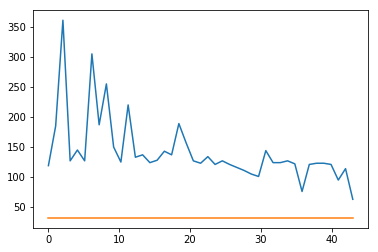

In [53]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0,len(cycle_list),len(cycle_list))
y = [32 for _ in range(len(cycle_list))]
plt.plot(x,cycle_list)
plt.plot(x,y)
plt.show()

In [28]:
row_n = 32
col_n = 1
myArray = SystolicArray(row_n, col_n)

#src = [0,1,2,1,2,0,2,0,1]
#dst = [0,1,2,0,1,2,0,1,2]

#src = [0,0,0,0,1,1,2,2,2]
#dst = [0,1,3,5,2,4,0,3,5]

#src = [0,1,1,2,0,0,0,2,2]
#dst = [0,2,4,0,1,3,5,3,5]

#src = [0,1,1,2,0,1,0,2,2]
#dst = [0,2,4,0,1,3,5,4,5]

#src = [0,0,1,2]
#dst = [0,1,2,0]

#myArray.fill_edges(2708, src, dst)
myArray.edge_load_balance(row_n, src, dst)

#idx = [0,1,2]
myArray.fill_idx(idx)
myArray.fill_result_banks(2708)       
edge_count = 0
res = myArray.run(2708)
#assert (res == np.matmul(activations, weights)).all()
#print('Systolic array matches numpy matmul')

-----Cycle----0----------
compute cell(0,0) src 0, dst 544
compute cell(0,15) src 15, dst 399
compute cell(0,23) src 23, dst 759
-----Cycle----1----------
compute cell(0,29) src 30, dst 285
-----Cycle----2----------
compute cell(0,12) src 14, dst 268
compute cell(0,28) src 30, dst 1148
-----Cycle----3----------
compute cell(0,7) src 10, dst 519
compute cell(0,28) src 31, dst 1116
-----Cycle----4----------
compute cell(0,5) src 9, dst 453
compute cell(0,10) src 14, dst 746
-----Cycle----5----------
compute cell(0,2) src 7, dst 258
compute cell(0,9) src 14, dst 393
compute cell(0,10) src 15, dst 234
compute cell(0,17) src 22, dst 2257
compute cell(0,20) src 25, dst 20
compute cell(0,26) src 31, dst 250
-----Cycle----6----------
compute cell(0,2) src 8, dst 258
compute cell(0,4) src 10, dst 420
compute cell(0,8) src 14, dst 8
compute cell(0,12) src 18, dst 1932
compute cell(0,14) src 20, dst 334
compute cell(0,20) src 26, dst 2612
compute cell(0,22) src 28, dst 1718
-----Cycle----7-------

In [16]:
edge_count

127